# Libraries

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Part A: Dataset (CIFAR-10)

In [2]:
# Define transforms for the dataset for pre-processing of the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std
])

# Download the CIFAR-10 dataset and do the necessary pre-processs
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Separate a validation set from the train dataset (as indicated in the question)
train_size = 40000
val_size = 10000

train_indices = list(range(0, train_size))
val_indices = list(range(train_size, train_size + val_size))

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# Data loaders for each set
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print dataset sizes
print(f"Training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")
print(f"Test set size: {len(test_dataset)}")

100%|██████████| 170M/170M [00:04<00:00, 41.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set size: 40000
Validation set size: 10000
Test set size: 10000


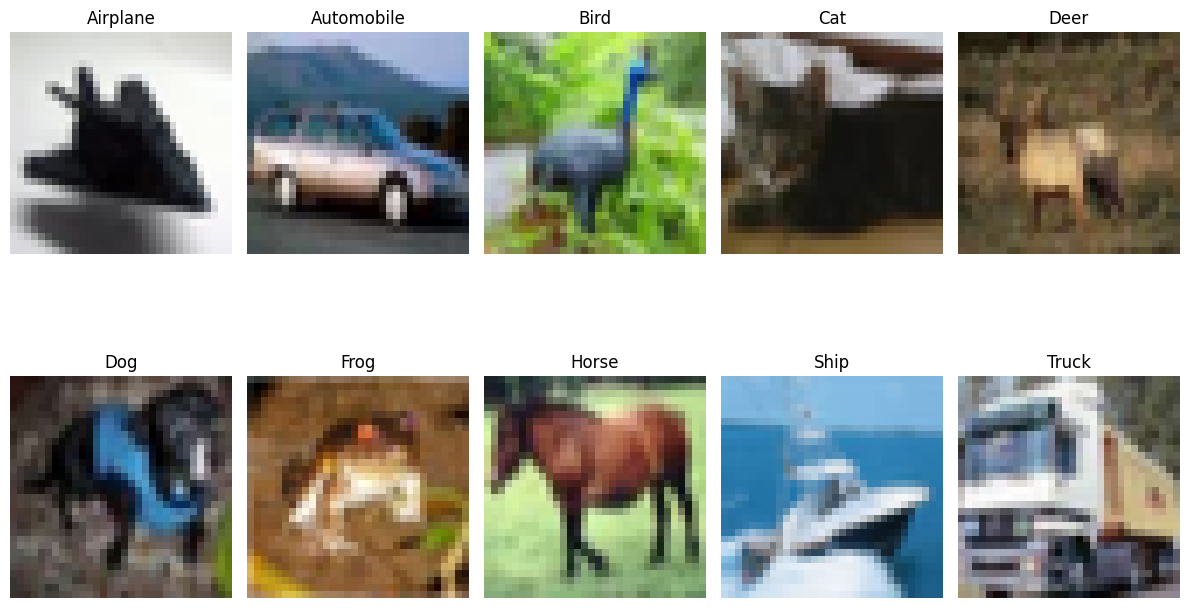

In [3]:
# We want to show a sample from each class

# Define CIFAR-10 classes
classes = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

# Create a dictionary to hold one random sample for each class
samples = {class_name: None for class_name in classes}

# Find one random sample per class
for idx, (image, label) in enumerate(train_dataset):
    class_name = classes[label]
    if samples[class_name] is None:
        samples[class_name] = (image, label)
    if all(v is not None for v in samples.values()):
        break

# Plot the samples
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(classes):
    image, label = samples[class_name]
    image = image / 2 + 0.5  # Reverses the normalization applied earlier
    np_image = image.numpy().transpose((1, 2, 0))

    plt.subplot(2, 5, i + 1)
    plt.imshow(np_image)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [4]:
batch_size = 64

# Create DataLoaders for train, validation, and test sets
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify batch shapes
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Batch of images shape: {images.shape}")  # Expected: (batch_size, 3, 32, 32)
print(f"Batch of labels shape: {labels.shape}")  # Expected: (batch_size,)


Batch of images shape: torch.Size([64, 3, 32, 32])
Batch of labels shape: torch.Size([64])


# Part B: Basedlind Model

In [5]:
# Define the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pre-defined model from the question
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Instantiate the model, loss function, and optimizer
baseline_model = BaselineModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(baseline_model.parameters(), lr=0.01, momentum=0.9)


Epoch 1/7
  Train Loss: 1.4738, Train Accuracy: 48.08%
  Validation Loss: 1.2489, Validation Accuracy: 56.88%
Epoch 2/7
  Train Loss: 1.1803, Train Accuracy: 59.20%
  Validation Loss: 1.1908, Validation Accuracy: 59.40%
Epoch 3/7
  Train Loss: 1.0685, Train Accuracy: 63.43%
  Validation Loss: 1.1314, Validation Accuracy: 61.56%
Epoch 4/7
  Train Loss: 0.9990, Train Accuracy: 65.93%
  Validation Loss: 1.1489, Validation Accuracy: 61.68%
Epoch 5/7
  Train Loss: 0.9567, Train Accuracy: 67.33%
  Validation Loss: 1.1512, Validation Accuracy: 61.93%
Epoch 6/7
  Train Loss: 0.9105, Train Accuracy: 68.80%
  Validation Loss: 1.1476, Validation Accuracy: 62.46%
Epoch 7/7
  Train Loss: 0.8656, Train Accuracy: 70.25%
  Validation Loss: 1.1692, Validation Accuracy: 61.85%


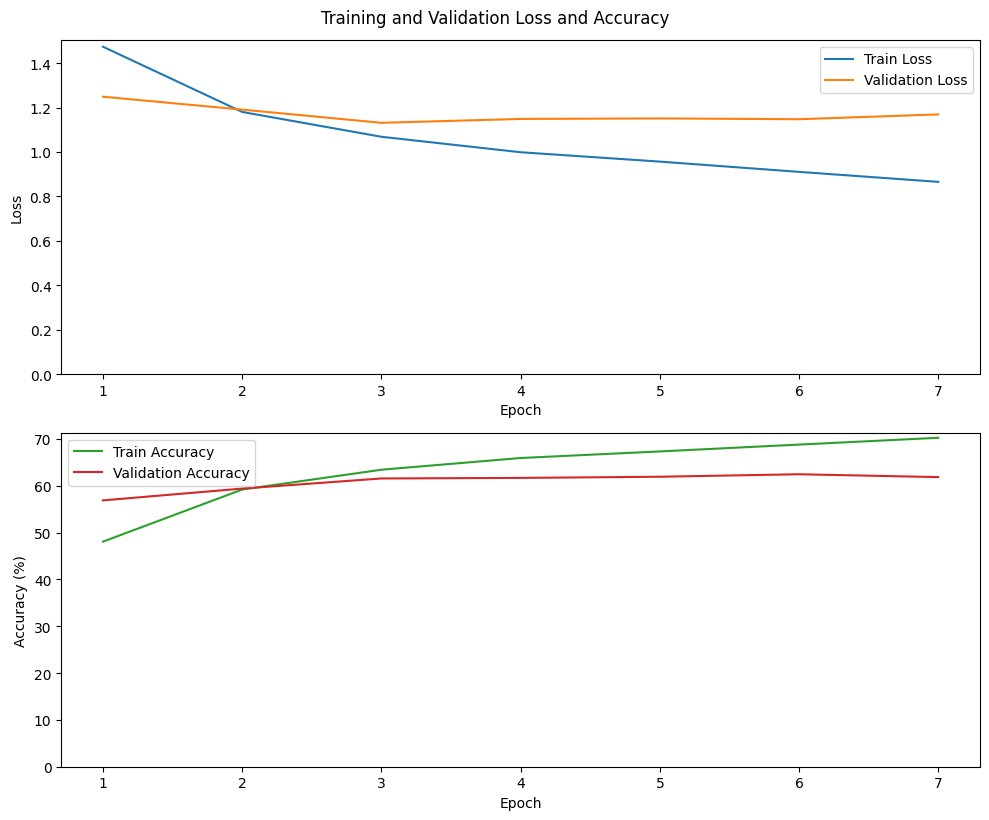

In [ ]:
# Lists to store loss and accuracy values for training and validation sets
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 7  # Set the number of epochs (I chose this number after a couple of training. It is suitable enough. I did the same for othe epoch numbers in this file.)
for epoch in range(num_epochs):
    # Train the model
    baseline_model.train()
    running_train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = baseline_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate running loss for training set
        running_train_loss += loss.item()

        # Calculate accuracy for training set
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for training set
    train_epoch_loss = running_train_loss / len(train_loader)
    train_epoch_accuracy = 100 * train_correct / train_total

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)

    # Evaluate the model on validation set
    baseline_model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # No gradient computation for validation
        for images, labels in val_loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass (no backward pass or optimization)
            outputs = baseline_model(images)
            loss = criterion(outputs, labels)

            # Calculate running loss for validation set
            running_val_loss += loss.item()

            # Calculate accuracy for validation set
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for validation set
    val_epoch_loss = running_val_loss / len(val_loader)
    val_epoch_accuracy = 100 * val_correct / val_total

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    # Print results for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.2f}%")
    print(f"  Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%")

# Plotting training and validation loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='tab:blue')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='tab:orange')
ax1.set_ylim(0)  # Set y-axis to start from zero
ax1.legend()

# Plot accuracy
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='tab:green')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='tab:red')
ax2.set_ylim(0)  # Set y-axis to start from zero
ax2.legend()

plt.tight_layout()
fig.suptitle('Training and Validation Loss and Accuracy', y=1.02)  # Adjust title for spacing
plt.show()

In [6]:
# Save the model's state_dict
torch.save(baseline_model.state_dict(), 'baseline_model.pth')

# Part C: Improved Model (With Additional Layers)

In [7]:
# Now we wanna Improve the Baseline model by adding more layers
class ImprovedBaselineModel(nn.Module):
    def __init__(self):
        super(ImprovedBaselineModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)  # 32x32 -> 32x32
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # 32x32 -> 32x32
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)  # 16x16 -> 16x16
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)  # 8x8 -> 8x8

        # Activation and pooling
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces dimensions by half

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 2 * 2, 512)  # Assuming input size is reduced to 2x2
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)  # Output layer (10 classes)

    def forward(self, x):
        # Convolutional layers with ReLU and MaxPooling
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # 32x32 -> 16x16

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)  # 16x16 -> 8x8

        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)  # 8x8 -> 4x4

        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)  # 4x4 -> 2x2

        # Fully connected layers
        x = self.flatten(x)  # Flatten before feeding into fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)  # Output layer

        return x

improved_model = ImprovedBaselineModel().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(improved_model.parameters(), lr=0.001)

Epoch 1/5
  Train Loss: 1.5145, Train Accuracy: 43.35%
  Validation Loss: 1.1251, Validation Accuracy: 59.21%
Epoch 2/5
  Train Loss: 0.9946, Train Accuracy: 64.49%
  Validation Loss: 0.9660, Validation Accuracy: 65.65%
Epoch 3/5
  Train Loss: 0.7558, Train Accuracy: 73.47%
  Validation Loss: 0.8233, Validation Accuracy: 71.23%
Epoch 4/5
  Train Loss: 0.5807, Train Accuracy: 79.59%
  Validation Loss: 0.7785, Validation Accuracy: 73.64%
Epoch 5/5
  Train Loss: 0.4464, Train Accuracy: 84.50%
  Validation Loss: 0.7600, Validation Accuracy: 75.73%


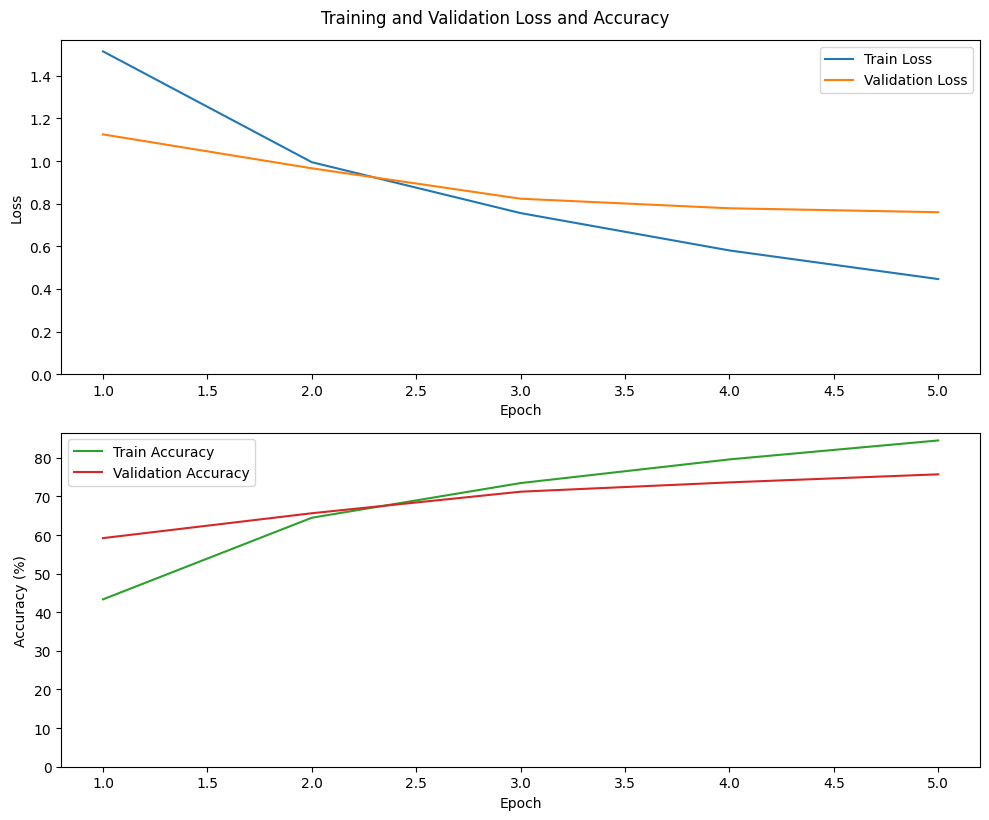

In [ ]:
# Training loop for Improved Baseline Model
num_epochs = 5  # Number of epochs
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    improved_model.train()
    running_train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = improved_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate running training loss and accuracy
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_epoch_loss = running_train_loss / len(train_loader)
    train_epoch_accuracy = 100 * train_correct / train_total
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)

    # Validation phase
    improved_model.eval()
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = improved_model(images)
            loss = criterion(outputs, labels)

            # Calculate running validation loss and accuracy
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = running_val_loss / len(val_loader)
    val_epoch_accuracy = 100 * val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    # Print results for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.2f}%")
    print(f"  Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%")

# Plotting training and validation metrics
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='tab:blue')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='tab:orange')
ax1.set_ylim(0)  # Set y-axis to start from zero
ax1.legend()

# Plot accuracy
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='tab:green')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='tab:red')
ax2.set_ylim(0)  # Set y-axis to start from zero
ax2.legend()

plt.tight_layout()
fig.suptitle('Training and Validation Loss and Accuracy', y=1.02)  # Adjust title for spacing
plt.show()

In [ ]:
torch.save(improved_model.state_dict(), 'improved_model.pth')

# Part D: Improved Model with Batch Normalization

In [8]:
# Now we wanna add bactch normalization
class ImprovedBaselineModelWithBN(nn.Module):
    def __init__(self):
        super(ImprovedBaselineModelWithBN, self).__init__()

        # Convolutional layers with Batch Normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        # Activation, pooling, and fully connected layers
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)

        self.fc2 = nn.Linear(1024, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)

        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)  # Flatten the output for fully connected layers

        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.relu(self.bn_fc2(self.fc2(x)))
        x = self.fc3(x)
        return x

improved_model_bn = ImprovedBaselineModelWithBN().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(improved_model_bn.parameters(), lr=0.01, momentum=0.9)


Epoch 1/5
  Train Loss: 1.1634, Train Accuracy: 58.39%
  Validation Loss: 0.9498, Validation Accuracy: 66.47%
Epoch 2/5
  Train Loss: 0.7646, Train Accuracy: 73.05%
  Validation Loss: 0.7575, Validation Accuracy: 72.94%
Epoch 3/5
  Train Loss: 0.5822, Train Accuracy: 79.50%
  Validation Loss: 0.6995, Validation Accuracy: 76.13%
Epoch 4/5
  Train Loss: 0.4436, Train Accuracy: 84.41%
  Validation Loss: 0.7523, Validation Accuracy: 75.72%
Epoch 5/5
  Train Loss: 0.3189, Train Accuracy: 88.88%
  Validation Loss: 0.7565, Validation Accuracy: 77.05%


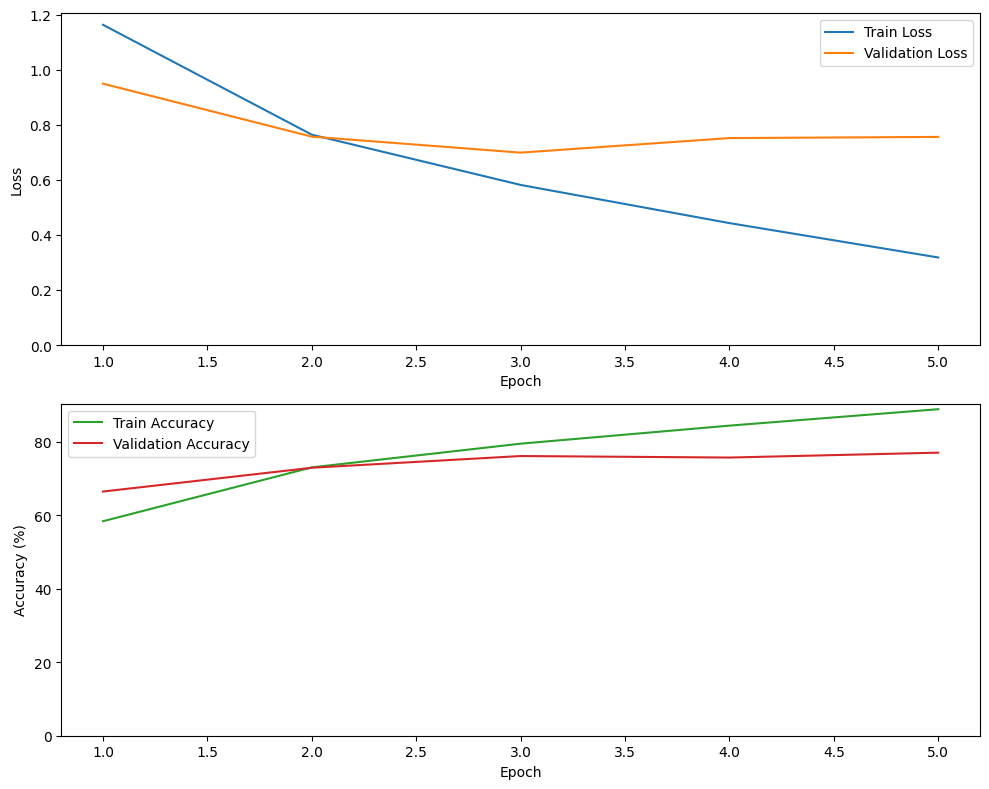

In [ ]:
# Lists to store loss and accuracy values for training and validation sets
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 5  # Set the number of epochs
for epoch in range(num_epochs):
    # Train the model
    improved_model_bn.train()  # Set model to training mode
    running_train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = improved_model_bn(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate running loss for training set
        running_train_loss += loss.item()

        # Calculate accuracy for training set
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for training set
    train_epoch_loss = running_train_loss / len(train_loader)
    train_epoch_accuracy = 100 * train_correct / train_total

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)

    # Evaluate the model on validation set
    improved_model_bn.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # No gradient computation for validation
        for images, labels in val_loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass (no backward pass or optimization)
            outputs = improved_model_bn(images)
            loss = criterion(outputs, labels)

            # Calculate running loss for validation set
            running_val_loss += loss.item()

            # Calculate accuracy for validation set
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for validation set
    val_epoch_loss = running_val_loss / len(val_loader)
    val_epoch_accuracy = 100 * val_correct / val_total

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    # Print results for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.2f}%")
    print(f"  Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%")

# Plotting training and validation loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='tab:blue')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='tab:orange')
ax1.legend()
ax1.set_ylim(0)  # Set y-axis to start from zero

# Plot accuracy
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='tab:green')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='tab:red')
ax2.legend()
ax2.set_ylim(0)  # Set y-axis to start from zero

plt.tight_layout()
plt.show()


Explanation: In Part C we reached the accuracy of 75.73 and with batch normalization wee reached 77.05. It shows that Bach Normalization can improve the overall generalization of the model

In [ ]:
torch.save(improved_model_bn.state_dict(), 'improved_model_bn.pth')

# Part E: Improved Model With Batch Normalization and Drop Out

In [ ]:
# Now we wanna add DropOut to fully connected layers
class ImprovedBaselineModelWithBNDropout(nn.Module):
    def __init__(self):
        super(ImprovedBaselineModelWithBNDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool1(self.bn1(F.relu(self.conv1(x))))
        x = self.pool2(self.bn2(F.relu(self.conv2(x))))
        x = self.pool3(self.bn3(F.relu(self.conv3(x))))
        x = self.pool4(self.bn4(F.relu(self.conv4(x))))

        x = x.view(-1, 256 * 2 * 2)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

model_with_dropout = ImprovedBaselineModelWithBNDropout().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_with_dropout.parameters(), lr=0.01, momentum=0.9)

Epoch 1/10
  Train Loss: 1.4563, Train Accuracy: 46.88%
  Validation Loss: 1.1698, Validation Accuracy: 58.46%
Epoch 2/10
  Train Loss: 1.0528, Train Accuracy: 63.27%
  Validation Loss: 0.9157, Validation Accuracy: 67.36%
Epoch 3/10
  Train Loss: 0.8596, Train Accuracy: 70.80%
  Validation Loss: 0.7902, Validation Accuracy: 72.97%
Epoch 4/10
  Train Loss: 0.7305, Train Accuracy: 75.28%
  Validation Loss: 0.7133, Validation Accuracy: 75.56%
Epoch 5/10
  Train Loss: 0.6246, Train Accuracy: 78.94%
  Validation Loss: 0.7622, Validation Accuracy: 74.21%
Epoch 6/10
  Train Loss: 0.5437, Train Accuracy: 81.73%
  Validation Loss: 0.6977, Validation Accuracy: 77.27%
Epoch 7/10
  Train Loss: 0.4656, Train Accuracy: 84.15%
  Validation Loss: 0.6881, Validation Accuracy: 78.20%
Epoch 8/10
  Train Loss: 0.4045, Train Accuracy: 86.40%
  Validation Loss: 0.6983, Validation Accuracy: 78.06%
Epoch 9/10
  Train Loss: 0.3462, Train Accuracy: 88.40%
  Validation Loss: 0.7050, Validation Accuracy: 78.23%
E

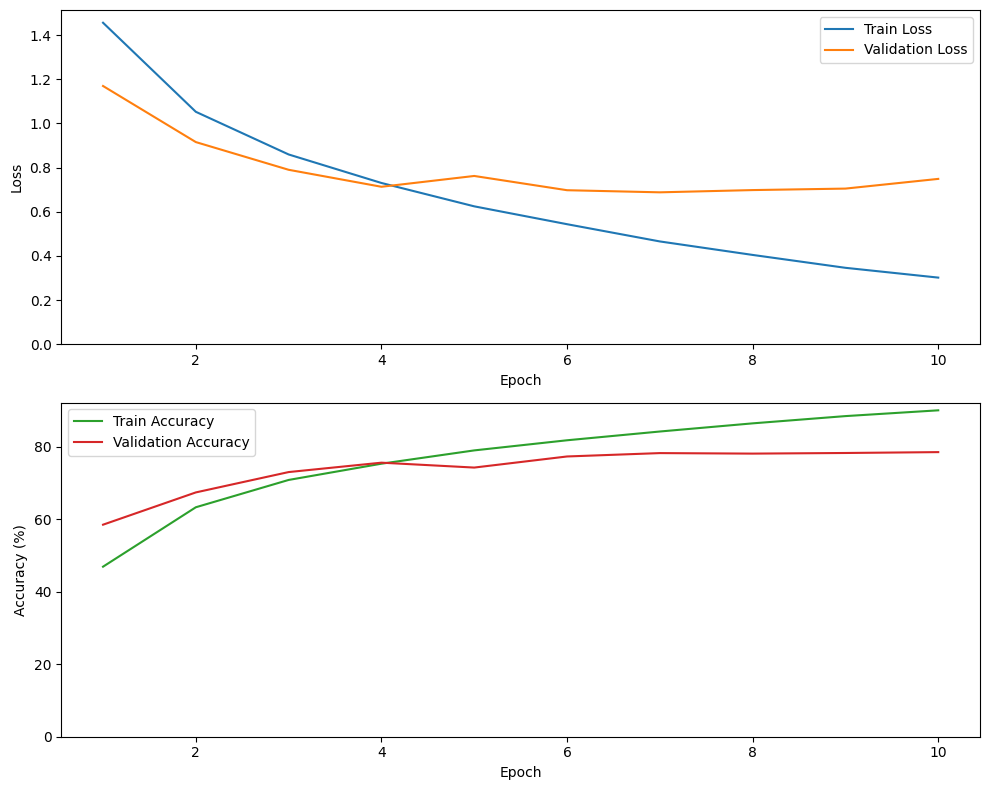

In [ ]:
# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 10  # Set the number of epochs
for epoch in range(num_epochs):
    # Train the model
    model_with_dropout.train()  # Set model to training mode
    running_train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_with_dropout(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate running loss for training set
        running_train_loss += loss.item()

        # Calculate accuracy for training set
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for training set
    train_epoch_loss = running_train_loss / len(train_loader)
    train_epoch_accuracy = 100 * train_correct / train_total

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)

    # Evaluate the model on validation set
    model_with_dropout.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model_with_dropout(images)
            loss = criterion(outputs, labels)

            # Calculate running loss for validation set
            running_val_loss += loss.item()

            # Calculate accuracy for validation set
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for validation set
    val_epoch_loss = running_val_loss / len(val_loader)
    val_epoch_accuracy = 100 * val_correct / val_total

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    # Print results
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.2f}%")
    print(f"  Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%")

# Plotting training and validation loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='tab:blue')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='tab:orange')
ax1.legend()
ax1.set_ylim(0)  # Start y-axis at zero

# Plot accuracy
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='tab:green')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='tab:red')
ax2.legend()
ax2.set_ylim(0)  # Start y-axis at zero

plt.tight_layout()
plt.show()


Explanation: Without Dropout we had the accuracy of 77.05 but using dropout, which is a regularization technique, in the FC layeys we reached 78.47 which shows that dropout is able to improve the overall generalization.

In [ ]:
torch.save(model_with_dropout.state_dict(), 'model_with_dropout.pth')

# Part F: Test the best Model (Last Model)

<ipython-input-28-bcf56a95d32e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_with_dropout.pth'))


Test Accuracy: 77.81%


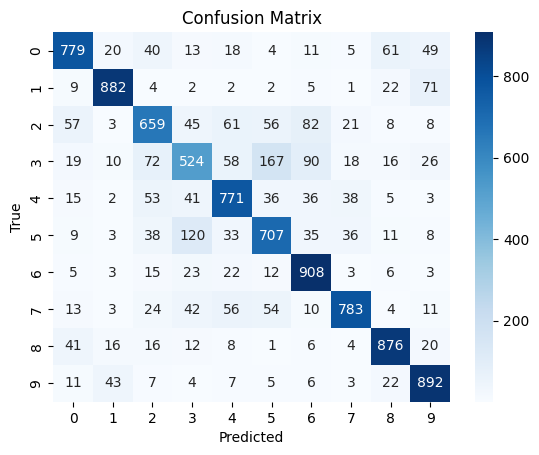

In [ ]:
# Load the saved model
model = ImprovedBaselineModelWithBNDropout()
model.load_state_dict(torch.load('model_with_dropout.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Initialize variables for storing predictions and true labels
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():  # No gradient computation for test set
    for images, labels in test_loader:  # Assume test_loader is already defined
        # Move data to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Store predictions and true labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate accuracy
accuracy = (all_predictions == all_labels).mean() * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
